### Loading Data

Reference : 
https://github.com/Luchkata/Algorithmic_Trading_Machine_Learning/blob/main/Algorithmic_Trading_Machine_Learning_Quant_Strategies.ipynb

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Define a list with the given ticker symbols
klci_stocks = [
    '5681.KL', '3182.KL', '1066.KL', '5285.KL', '5296.KL', '1295.KL',
    '1082.KL', '5183.KL', '7084.KL', '1155.KL', '5819.KL', '1015.KL',
    '4863.KL', '5225.KL', '4715.KL', '5347.KL', '1961.KL', '1023.KL',
    '6888.KL', '4707.KL', '4065.KL', '6947.KL', '6012.KL', '2445.KL',
    '3816.KL', '4197.KL', '4677.KL', '6033.KL', '6742.KL', '8869.KL'
]

# Display the list
print(klci_stocks)

['5681.KL', '3182.KL', '1066.KL', '5285.KL', '5296.KL', '1295.KL', '1082.KL', '5183.KL', '7084.KL', '1155.KL', '5819.KL', '1015.KL', '4863.KL', '5225.KL', '4715.KL', '5347.KL', '1961.KL', '1023.KL', '6888.KL', '4707.KL', '4065.KL', '6947.KL', '6012.KL', '2445.KL', '3816.KL', '4197.KL', '4677.KL', '6033.KL', '6742.KL', '8869.KL']


In [3]:
#Extract 8 years data of stocks listed from yfinance


end_date = '2024-03-31'

start_date = '2022-01-01'

df = yf.download(tickers=klci_stocks,
                 start=start_date,
                 end=end_date).stack()

#set date and ticker as index
df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()



[*********************100%%**********************]  30 of 30 completed


## Calculate Technical Indicator



In [4]:
!pip install pandas-ta
import pandas_ta as ta

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

##################can try adjust length
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close  close       high    low   open   volume  \
date       ticker                                                        
2022-01-03 1015.KL   2.848593   3.20   3.200000   3.16   3.17   251700   
           1023.KL   4.897363   5.49   5.500000   5.40   5.40  2735700   
           1066.KL   4.487800   5.40   5.420000   5.36   5.37   898300   
           1082.KL  16.278486  17.34  17.559999  17.32  17.34    49100   
           1155.KL   7.058859   8.33   8.340000   8.26   8.29  1600100   
...                       ...    ...        ...    ...    ...      ...   
2024-03-29 6742.KL   3.847055   3.87   3.910000   3.72   3.78  8607300   
           6888.KL   2.690000   2.69   2.720000   2.66   2.70  5720000   
           6947.KL   4.151204   4.19   4.240000   4.16   4.21  4645600   
           7084.KL   5.900000   5.90   5.930000   5.87   5.90  1660300   
           8869.KL   4.636437   4.65   4.700000   4.61   4.65  4053300   

Price               garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                               
2022-01-03 1015.KL         -0.004336        NaN       NaN       NaN       NaN   
           1023.KL         -0.003519        NaN       NaN       NaN       NaN   
           1066.KL         -0.012380        NaN       NaN       NaN       NaN   
           1082.KL         -0.001447        NaN       NaN       NaN       NaN   
           1155.KL         -0.009938        NaN       NaN       NaN       NaN   
...                              ...        ...       ...       ...       ...   
2024-03-29 6742.KL          0.001121  54.050061  1.519660  1.565212  1.610764   
           6888.KL          0.000243  49.077906  1.284648  1.316465  1.348281   
           6947.KL          0.000105  46.809822  1.628256  1.654464  1.680672   
           7084.KL          0.000052  53.468877  1.923734  1.933761  1.943788   
           8869.KL          0.000184  49.461722  1.702622  1.724245  1.745869   

Price                    atr      macd  dollar_volume  
date       ticker                                      
2022-01-03 1015.KL       NaN       NaN       0.716991  
           1023.KL       NaN       NaN      13.397716  
           1066.KL       NaN       NaN       4.031391  
           1082.KL       NaN       NaN       0.799274  
           1155.KL       NaN       NaN      11.294881  
...                      ...       ...            ...  
2024-03-29 6742.KL  2.040267 -0.521378      33.112758  
           6888.KL -0.351419  0.576776      15.386800  
           6947.KL  0.286182 -0.102635      19.284832  
           7084.KL -1.228261 -0.139360       9.795770  
           8869.KL -1.085368  0.137462      18.792872  

[16410 rows x 14 columns]

In [6]:
#To reduce training time and experiment with features and strategies
#convert the business-daily data to month-end frequency.

last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

monthdata = df.unstack()[last_cols].resample('M').last().stack('ticker').dropna()


monthdata

Price               adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2022-02-28 1015.KL   2.991023         -0.005711  53.862818  1.357665   
           1023.KL   5.093615         -0.004170  58.613733  1.722496   
           1066.KL   4.903337         -0.008949  65.670488  1.717527   
           1082.KL  18.137274         -0.000626  66.292879  2.886708   
           1155.KL   7.423243         -0.012173  60.382360  2.071872   
...                       ...               ...        ...       ...   
2024-03-31 6742.KL   3.847055          0.001121  54.050061  1.519660   
           6888.KL   2.690000          0.000243  49.077906  1.284648   
           6947.KL   4.151204          0.000105  46.809822  1.628256   
           7084.KL   5.900000          0.000052  53.468877  1.923734   
           8869.KL   4.636437          0.000184  49.461722  1.702622   

Price                 bb_mid   bb_high       atr      macd  
date       ticker                                           
2022-02-28 1015.KL  1.381409  1.405153  1.407186 -0.581716  
           1023.KL  1.772828  1.823159  0.829422  0.369425  
           1066.KL  1.745555  1.773583  1.730705  0.669785  
           1082.KL  2.931817  2.976927  1.420209  2.215301  
           1155.KL  2.111195  2.150517  1.799739  1.394435  
...                      ...       ...       ...       ...  
2024-03-31 6742.KL  1.565212  1.610764  2.040267 -0.521378  
           6888.KL  1.316465  1.348281 -0.351419  0.576776  
           6947.KL  1.654464  1.680672  0.286182 -0.102635  
           7084.KL  1.933761  1.943788 -1.228261 -0.139360  
           8869.KL  1.724245  1.745869 -1.085368  0.137462  

[780 rows x 8 columns]

## Monthly Returns for Different Time Horizon

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 3,6,9]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
monthdata = monthdata.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
monthdata

Price               adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2022-11-30 1015.KL   3.762509         -0.002124  60.929054  1.496554   
           1023.KL   5.431500         -0.001680  65.270145  1.770601   
           1066.KL   5.004465         -0.006117  53.189001  1.760247   
           1082.KL  17.813480         -0.000777  46.896832  2.926118   
           1155.KL   7.813042         -0.004424  52.186208  2.152316   
...                       ...               ...        ...       ...   
2024-03-31 6742.KL   3.847055          0.001121  54.050061  1.519660   
           6888.KL   2.690000          0.000243  49.077906  1.284648   
           6947.KL   4.151204          0.000105  46.809822  1.628256   
           7084.KL   5.900000          0.000052  53.468877  1.923734   
           8869.KL   4.636437          0.000184  49.461722  1.702622   

Price                 bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                       
2022-11-30 1015.KL  1.524800  1.553045  1.237870  0.381461   0.019560   
           1023.KL  1.819135  1.867669  1.668058  1.434010   0.050725   
           1066.KL  1.782754  1.805260  0.779078  0.110867  -0.017483   
           1082.KL  2.944779  2.963440  0.660553  0.711895  -0.013094   
           1155.KL  2.169702  2.187088  1.563968 -0.252170   0.004657   
...                      ...       ...       ...       ...        ...   
2024-03-31 6742.KL  1.565212  1.610764  2.040267 -0.521378  -0.020253   
           6888.KL  1.316465  1.348281 -0.351419  0.576776  -0.014908   
           6947.KL  1.654464  1.680672  0.286182 -0.102635  -0.028840   
           7084.KL  1.933761  1.943788 -1.228261 -0.139360   0.020602   
           8869.KL  1.724245  1.745869 -1.085368  0.137462  -0.002665   

Price               return_3m  return_6m  return_9m  
date       ticker                                    
2022-11-30 1015.KL  -0.000798   0.025217   0.025789  
           1023.KL   0.034620   0.024279   0.007162  
           1066.KL   0.001880  -0.008222   0.002271  
           1082.KL  -0.010228  -0.011472  -0.002000  
           1155.KL  -0.002174  -0.003480   0.005703  
...                       ...        ...        ...  
2024-03-31 6742.KL   0.150692   0.114622   0.130830  
           6888.KL   0.047888   0.015984   0.005980  
           6947.KL   0.011673  -0.004330   0.004747  
           7084.KL   0.012664   0.013849   0.012001  
           8869.KL  -0.009972  -0.000917   0.000023  

[510 rows x 12 columns]

## FAMA-FRENCH FIVE FACTOR


In [8]:
factor_data = web.DataReader('Emerging_5_Factors',
                               'famafrench',
                               start='2022')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(monthdata['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                    
2022-11-30 1015.KL  0.1255 -0.0295 -0.0347  0.0276 -0.0378   0.019560
           1023.KL  0.1255 -0.0295 -0.0347  0.0276 -0.0378   0.050725
           1066.KL  0.1255 -0.0295 -0.0347  0.0276 -0.0378  -0.017483
           1082.KL  0.1255 -0.0295 -0.0347  0.0276 -0.0378  -0.013094
           1155.KL  0.1255 -0.0295 -0.0347  0.0276 -0.0378   0.004657
...                    ...     ...     ...     ...     ...        ...
2024-03-31 6742.KL  0.0122 -0.0320 -0.0070  0.0181  0.0010  -0.020253
           6888.KL  0.0122 -0.0320 -0.0070  0.0181  0.0010  -0.014908
           6947.KL  0.0122 -0.0320 -0.0070  0.0181  0.0010  -0.028840
           7084.KL  0.0122 -0.0320 -0.0070  0.0181  0.0010   0.020602
           8869.KL  0.0122 -0.0320 -0.0070  0.0181  0.0010  -0.002665

[510 rows x 6 columns]

In [9]:
#calculate rolling factor betas

betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(6, x.shape[0]),
                                     min_nobs=len(x.columns))
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF        SMB       HML        RMW        CMA
date       ticker                                                      
2022-11-30 1015.KL       NaN        NaN       NaN        NaN        NaN
           1023.KL       NaN        NaN       NaN        NaN        NaN
           1066.KL       NaN        NaN       NaN        NaN        NaN
           1082.KL       NaN        NaN       NaN        NaN        NaN
           1155.KL       NaN        NaN       NaN        NaN        NaN
...                      ...        ...       ...        ...        ...
2024-03-31 6742.KL  8.600192  36.324403  7.874575  91.320995 -35.992562
           6888.KL  3.266838   9.536649  3.773191  32.134982 -22.950378
           6947.KL  2.578032  11.131018  0.282031  28.340778 -16.323305
           7084.KL  0.143707  -0.083430  0.305682   0.043826   2.335851
           8869.KL -1.599427  -4.737658 -0.679766 -14.504947   8.190131

[510 rows x 5 columns]

In [10]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

proc_data = (monthdata.join(betas.groupby('ticker').shift()))

proc_data.loc[:, factors] = proc_data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

proc_data = proc_data.drop('adj close', axis=1)

proc_data = proc_data.dropna()

proc_data.info()

proc_data

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 510 entries, (Timestamp('2022-11-30 00:00:00'), '1015.KL') to (Timestamp('2024-03-31 00:00:00'), '8869.KL')
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  510 non-null    float64
 1   rsi               510 non-null    float64
 2   bb_low            510 non-null    float64
 3   bb_mid            510 non-null    float64
 4   bb_high           510 non-null    float64
 5   atr               510 non-null    float64
 6   macd              510 non-null    float64
 7   return_1m         510 non-null    float64
 8   return_3m         510 non-null    float64
 9   return_6m         510 non-null    float64
 10  return_9m         510 non-null    float64
 11  Mkt-RF            510 non-null    float64
 12  SMB               510 non-null    float64
 13  HML               510 non-null    float64
 14  RMW               510 non-null    float64
 15  CMA  

garman_klass_vol        rsi    bb_low    bb_mid   bb_high  \
date       ticker                                                               
2022-11-30 1015.KL         -0.002124  60.929054  1.496554  1.524800  1.553045   
           1023.KL         -0.001680  65.270145  1.770601  1.819135  1.867669   
           1066.KL         -0.006117  53.189001  1.760247  1.782754  1.805260   
           1082.KL         -0.000777  46.896832  2.926118  2.944779  2.963440   
           1155.KL         -0.004424  52.186208  2.152316  2.169702  2.187088   
...                              ...        ...       ...       ...       ...   
2024-03-31 6742.KL          0.001121  54.050061  1.519660  1.565212  1.610764   
           6888.KL          0.000243  49.077906  1.284648  1.316465  1.348281   
           6947.KL          0.000105  46.809822  1.628256  1.654464  1.680672   
           7084.KL          0.000052  53.468877  1.923734  1.933761  1.943788   
           8869.KL          0.000184  49.461722  1.702622  1.724245  1.745869   

                         atr      macd  return_1m  return_3m  return_6m  \
date       ticker                                                         
2022-11-30 1015.KL  1.237870  0.381461   0.019560  -0.000798   0.025217   
           1023.KL  1.668058  1.434010   0.050725   0.034620   0.024279   
           1066.KL  0.779078  0.110867  -0.017483   0.001880  -0.008222   
           1082.KL  0.660553  0.711895  -0.013094  -0.010228  -0.011472   
           1155.KL  1.563968 -0.252170   0.004657  -0.002174  -0.003480   
...                      ...       ...        ...        ...        ...   
2024-03-31 6742.KL  2.040267 -0.521378  -0.020253   0.150692   0.114622   
           6888.KL -0.351419  0.576776  -0.014908   0.047888   0.015984   
           6947.KL  0.286182 -0.102635  -0.028840   0.011673  -0.004330   
           7084.KL -1.228261 -0.139360   0.020602   0.012664   0.013849   
           8869.KL -1.085368  0.137462  -0.002665  -0.009972  -0.000917   

                    return_9m     Mkt-RF        SMB        HML         RMW  \
date       ticker                                                            
2022-11-30 1015.KL   0.025789   0.705877   1.366365  -3.752552   -3.676986   
           1023.KL   0.007162  -0.666347  -0.410821   1.097990   -3.792571   
           1066.KL   0.002271  -0.351038  -0.767344   1.173156   -1.114832   
           1082.KL  -0.002000  -0.641592  -1.247192   3.290077    1.732200   
           1155.KL   0.005703   0.035005  -0.438835   0.128389    4.000579   
...                       ...        ...        ...        ...         ...   
2024-03-31 6742.KL   0.130830   1.280250  26.954074   4.376697    2.897177   
           6888.KL   0.005980  19.923215  30.858639  11.732539  233.341558   
           6947.KL   0.004747  12.679356  24.061821   5.109008  150.363277   
           7084.KL   0.012001  -1.711782  -2.458659  -0.580974  -22.370203   
           8869.KL   0.000023  -8.687536 -13.811215  -4.066861 -100.128259   

                          CMA  
date       ticker              
2022-11-30 1015.KL   1.762447  
           1023.KL  -5.810692  
           1066.KL  -1.922830  
           1082.KL  -5.589854  
           1155.KL  -1.484478  
...                       ...  
2024-03-31 6742.KL -27.683999  
           6888.KL -41.856342  
           6947.KL -27.788899  
           7084.KL   4.441939  
           8869.KL  16.235550  

[510 rows x 16 columns]

In [11]:
#make a copy
Fuzzy_copy = proc_data.copy()

# GaussianMixtureModel
### Model-Based Clustering

In [12]:
np.random.seed(42)

trying out different combinations of parameters

In [13]:
from statistics import mean 
from sklearn.metrics import silhouette_score

def calculate_centroid (data, K, U, m):
    Centroids=np.zeros((K,data.shape[1]))
    for i in range (K):
        Centroids[i,:]=np.sum((U[:,i]**m)[:,np.newaxis]*data, axis=0)/np.sum(U[:,i]**m)
    return Centroids

def calculate_membership (data, Centroids, K , m):
    U_new=np.zeros((data.shape[0],K))
    for i in range (K):
        U_new[:,i]=np.linalg.norm(data-Centroids[i,:],axis=1)

    U_new=1/ (U_new ** (2/(m-1)) * np.sum((1/U_new) ** (2/(m-1)) , axis=1 )[:,np.newaxis] )
    return U_new


def get_clusters(df,K,m):

    Fuzzy_array = np.array(df)

    U=np.random.rand(df.shape[0],K)
    U/=np.sum(U, axis=1)[:,np.newaxis]

    max_iteration=100
    for iteration in range (max_iteration):
        Centroids=calculate_centroid(Fuzzy_array, K, U , m)
        U_new= calculate_membership (Fuzzy_array,Centroids, K , m )
    
        if np.linalg.norm (U_new- U)<=0.00001:
            break
        U=U_new
    
    df['cluster']=np.argmax(U_new, axis=1)
    
    return df

K_range = [2,3,4,5]
m_range = np.linspace(1.1, 5.0, 10)
max_silhouette_score = -1  # Initialize with a very low value
best_K = None
best_m = None

silhouette_score_list = []

for K in K_range:
    for m in m_range:
        Fuzzy_df_data = get_clusters(Fuzzy_copy, K, m)
        labels = Fuzzy_df_data['cluster'].values
        silhouette = silhouette_score(Fuzzy_df_data, labels)
        
        # Append silhouette_avg to a list if you need to track all scores
        silhouette_score_list.append(silhouette_score)
        
        # Check if this silhouette average is the highest found so far
        if silhouette > max_silhouette_score:
            max_silhouette_score = silhouette
            best_K = K
            best_m = m

# Print the maximum silhouette average and the corresponding K and m values
print(f"Max silhouette score: {max_silhouette_score}")
print(f"Corresponding K: {best_K}")
print(f"Corresponding m: {best_m}")

Max silhouette score: 0.816031323252883
Corresponding K: 3
Corresponding m: 1.1


In [14]:
def calculate_centroid (data, K, U, m):
    Centroids=np.zeros((K,data.shape[1]))
    for i in range (K):
        Centroids[i,:]=np.sum((U[:,i]**m)[:,np.newaxis]*data, axis=0)/np.sum(U[:,i]**m)
    return Centroids

def calculate_membership (data, Centroids, K , m):
    U_new=np.zeros((data.shape[0],K))
    for i in range (K):
        U_new[:,i]=np.linalg.norm(data-Centroids[i,:],axis=1)

    U_new=1/ (U_new ** (2/(m-1)) * np.sum((1/U_new) ** (2/(m-1)) , axis=1 )[:,np.newaxis] )
    return U_new

K=3
m=1.1

def get_clusters(df):


    Fuzzy_array = np.array(df)

    U=np.random.rand(df.shape[0],K)
    U/=np.sum(U, axis=1)[:,np.newaxis]

    max_iteration=100
    for iteration in range (max_iteration):
        Centroids=calculate_centroid(Fuzzy_array, K, U , m)
        U_new= calculate_membership (Fuzzy_array,Centroids, K , m )
    
        if np.linalg.norm (U_new- U)<=0.00001:
            break
        U=U_new
    
    df['cluster']=np.argmax(U_new, axis=1)
    
    return df

FCM_result = Fuzzy_copy.dropna().groupby('date', group_keys=False).apply(get_clusters)


In [15]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]



    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')

    
    plt.legend()
    plt.show()
    return

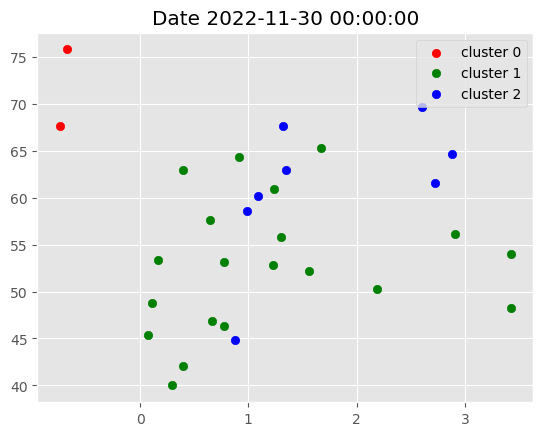

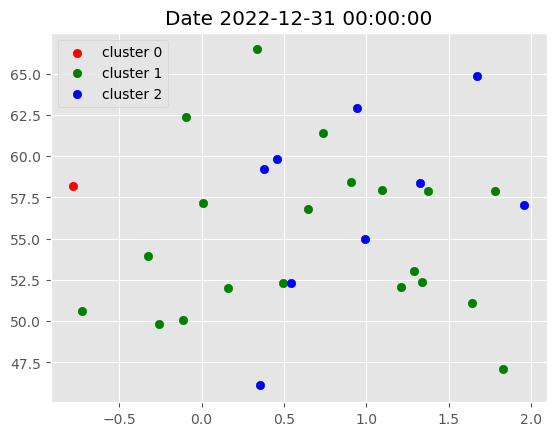

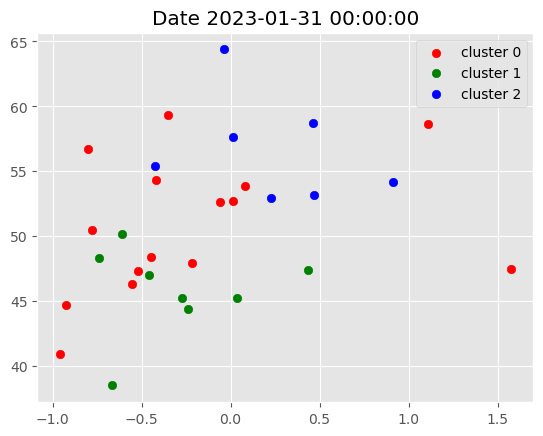

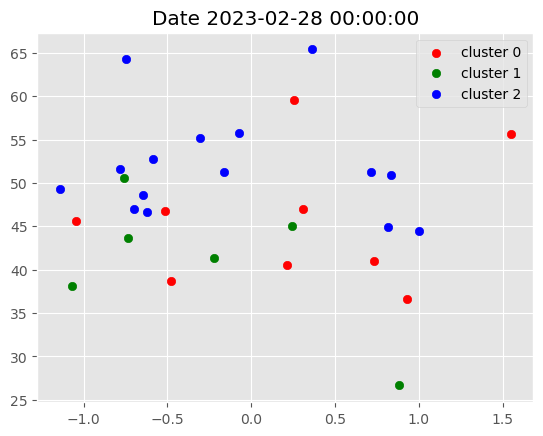

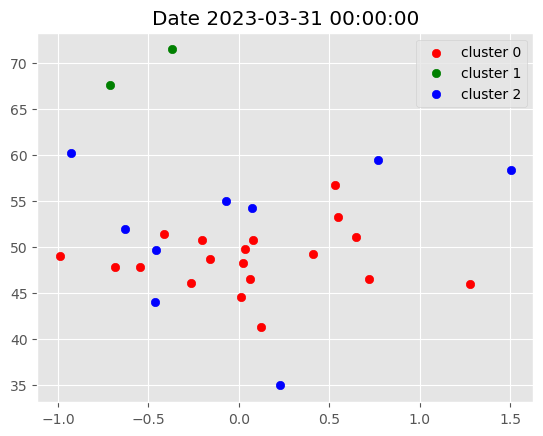

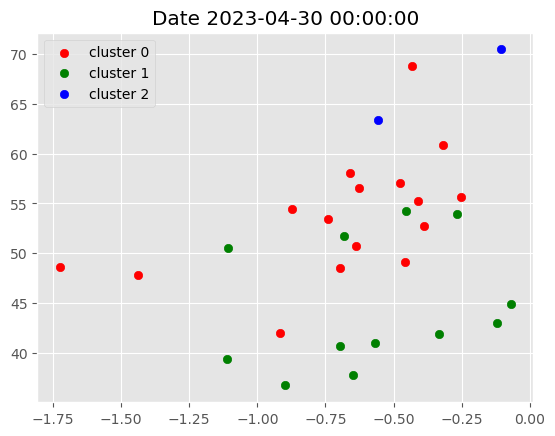

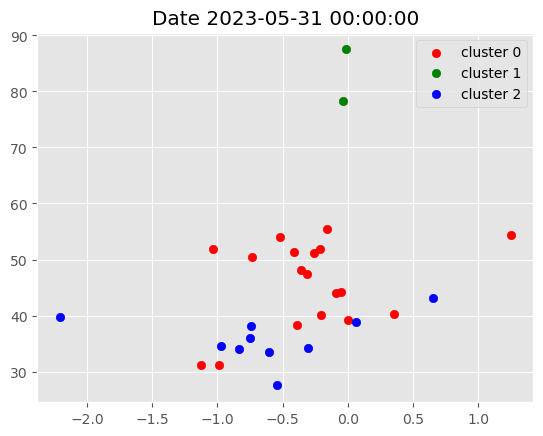

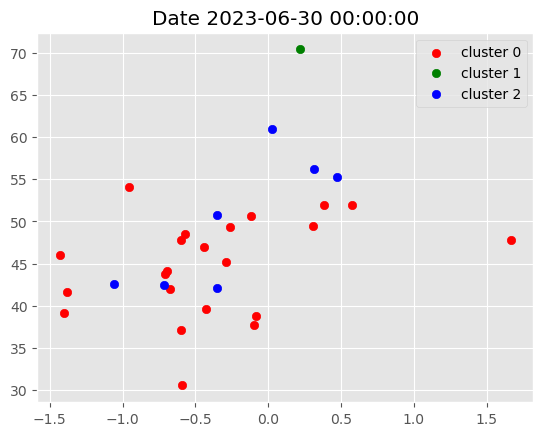

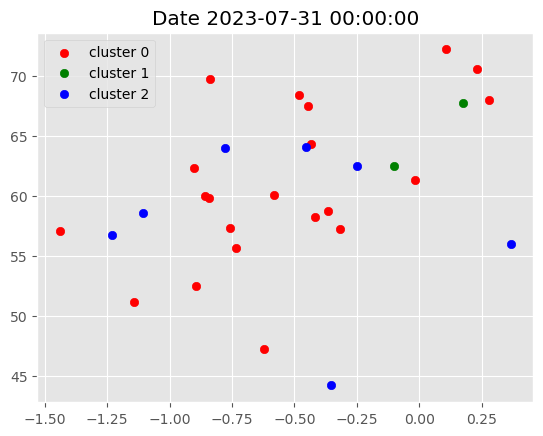

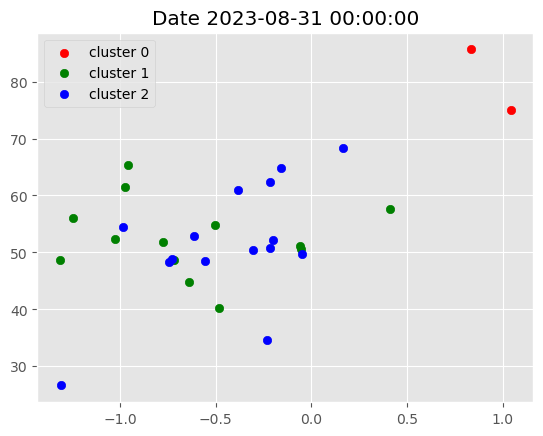

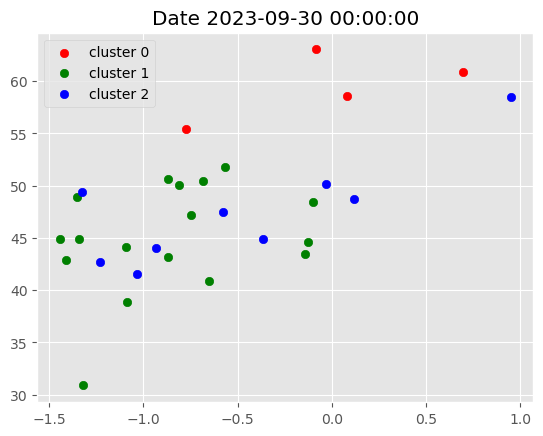

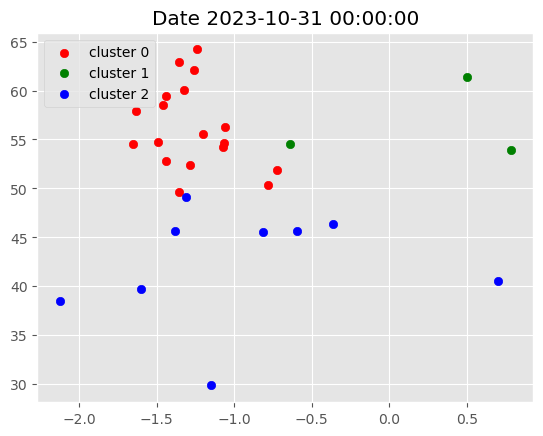

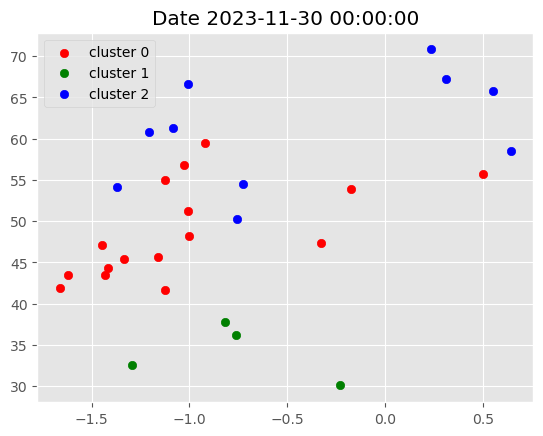

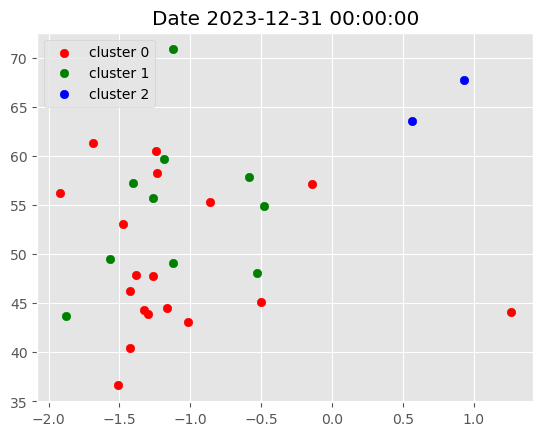

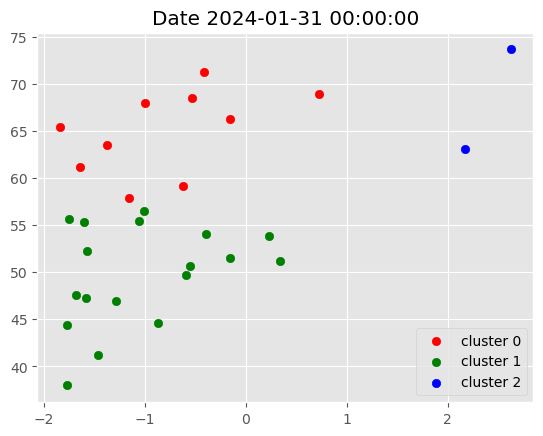

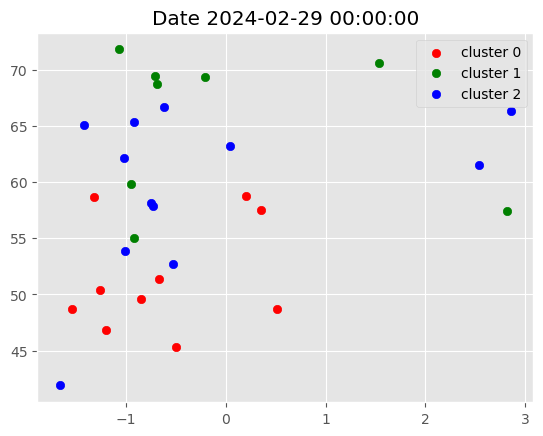

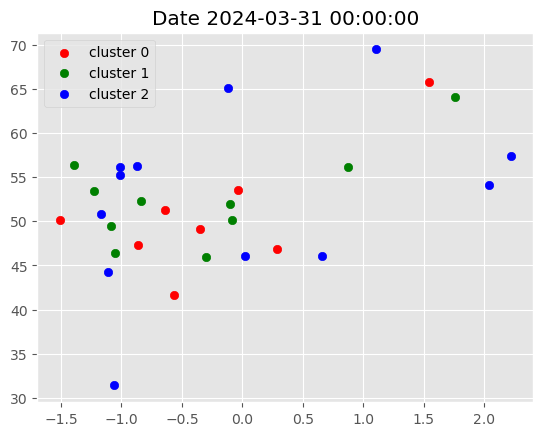

In [16]:
plt.style.use('ggplot')

monthly_silhouette = []

for i in FCM_result.index.get_level_values('date').unique().tolist():
    
    g = FCM_result.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)
    
    silhouette = silhouette_score(g,g['cluster'])

    monthly_silhouette.append(silhouette)

In [17]:
from statistics import mean 


print('the mean silhouette score across months :',mean(monthly_silhouette))

the mean silhouette score across months : 0.3412770153061214


In [32]:
#selecting cluster with higher average RSI value
rsi_values={}
selected_clusters={}
for i in FCM_result.index.get_level_values('date').unique().tolist():
    
    month_data = FCM_result.xs(i, level=0)

    # Calculate average RSI for each cluster
    avg_rsi_per_cluster = month_data.groupby('cluster')['rsi'].mean()
    print(avg_rsi_per_cluster)
    
    # Select cluster with highest average RSI
    cluster_with_highest_rsi = avg_rsi_per_cluster.idxmax()
    
    selected_clusters[i] = cluster_with_highest_rsi
    rsi_values[i]=avg_rsi_per_cluster

selected_clusters

cluster
0    71.690810
1    52.826357
2    61.252821
Name: rsi, dtype: float64
cluster
0    58.213156
1    55.040577
2    57.295087
Name: rsi, dtype: float64
cluster
0    50.789948
1    45.777377
2    56.634349
Name: rsi, dtype: float64
cluster
0    45.701751
1    40.890436
2    51.956098
Name: rsi, dtype: float64
cluster
0    48.729123
1    69.537661
2    51.975414
Name: rsi, dtype: float64
cluster
0    53.723052
1    44.644603
2    66.956632
Name: rsi, dtype: float64
cluster
0    45.803555
1    82.879804
2    35.965034
Name: rsi, dtype: float64
cluster
0    44.737192
1    70.402916
2    50.067080
Name: rsi, dtype: float64
cluster
0    60.912260
1    65.091296
2    58.003234
Name: rsi, dtype: float64
cluster
0    80.284225
1    52.598236
2    51.572273
Name: rsi, dtype: float64
cluster
0    59.490524
1    45.069013
2    47.476235
Name: rsi, dtype: float64
cluster
0    56.235031
1    56.629169
2    42.313847
Name: rsi, dtype: float64
cluster
0    48.796824
1    34.162557
2    60.999337

{Timestamp('2022-11-30 00:00:00'): 0,
 Timestamp('2022-12-31 00:00:00'): 0,
 Timestamp('2023-01-31 00:00:00'): 2,
 Timestamp('2023-02-28 00:00:00'): 2,
 Timestamp('2023-03-31 00:00:00'): 1,
 Timestamp('2023-04-30 00:00:00'): 2,
 Timestamp('2023-05-31 00:00:00'): 1,
 Timestamp('2023-06-30 00:00:00'): 1,
 Timestamp('2023-07-31 00:00:00'): 1,
 Timestamp('2023-08-31 00:00:00'): 0,
 Timestamp('2023-09-30 00:00:00'): 0,
 Timestamp('2023-10-31 00:00:00'): 1,
 Timestamp('2023-11-30 00:00:00'): 2,
 Timestamp('2023-12-31 00:00:00'): 2,
 Timestamp('2024-01-31 00:00:00'): 2,
 Timestamp('2024-02-29 00:00:00'): 1,
 Timestamp('2024-03-31 00:00:00'): 2}

In [19]:
# Initialize an empty dataframe to store filtered results
FCM_filtered_data = pd.DataFrame()

# Iterate over each month and filter data accordingly
# Filter the dataframe to keep only the chosen clusters accordingly
for month, chosen_clusters in selected_clusters.items():

    FCM_filtered_df = FCM_result[(FCM_result.index.get_level_values('date') == month) &
                                      (FCM_result['cluster'] == chosen_clusters)].copy()
    
    # Concatenate filtered DataFrame to the main dataframe
    FCM_filtered_data = pd.concat([FCM_filtered_data, FCM_filtered_df], ignore_index=False)


In [20]:
#keep only the date and tickers
#the list of index is set for investment of next month
filtered_df = FCM_filtered_data.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2022-12-01': ['4677.KL', '6742.KL'],
 '2023-01-01': ['4677.KL'],
 '2023-02-01': ['3182.KL',
  '4065.KL',
  '4197.KL',
  '4715.KL',
  '6012.KL',
  '6888.KL',
  '6947.KL'],
 '2023-03-01': ['1015.KL',
  '1023.KL',
  '1066.KL',
  '1082.KL',
  '1155.KL',
  '1961.KL',
  '2445.KL',
  '3816.KL',
  '4065.KL',
  '5347.KL',
  '5819.KL',
  '6033.KL',
  '6742.KL',
  '7084.KL',
  '8869.KL'],
 '2023-04-01': ['4677.KL', '6742.KL'],
 '2023-05-01': ['4677.KL', '6742.KL'],
 '2023-06-01': ['4677.KL', '6742.KL'],
 '2023-07-01': ['4677.KL'],
 '2023-08-01': ['4677.KL', '6742.KL'],
 '2023-09-01': ['4677.KL', '6742.KL'],
 '2023-10-01': ['4197.KL', '5183.KL', '5347.KL', '6742.KL'],
 '2023-11-01': ['4677.KL', '5183.KL', '6742.KL'],
 '2023-12-01': ['3182.KL',
  '4197.KL',
  '4677.KL',
  '4715.KL',
  '4863.KL',
  '5183.KL',
  '5285.KL',
  '5347.KL',
  '6742.KL',
  '6947.KL'],
 '2024-01-01': ['4677.KL', '6742.KL'],
 '2024-02-01': ['4677.KL', '6742.KL'],
 '2024-03-01': ['1015.KL',
  '1023.KL',
  '1155.KL',
  '2445

In [21]:
stock_frequency = filtered_df.index.get_level_values('ticker').value_counts()


## Optimization

In [22]:
!pip install PyPortfolioOpt

In [23]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [24]:
stocks = FCM_result.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=FCM_result.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=FCM_result.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  30 of 30 completed


Price      Adj Close                                                     \
Ticker       1015.KL   1023.KL   1066.KL    1082.KL   1155.KL   1295.KL   
Date                                                                      
2021-11-30  2.812986  4.620827  4.388072  16.147058  6.762269  3.562227   
2021-12-01  2.750673  4.487020  4.354828  16.316038  6.736847  3.535104   
2021-12-02  2.804084  4.602987  4.354828  16.297262  6.736847  3.535104   
2021-12-06  2.804084  4.674351  4.363139  16.147058  6.770742  3.507980   
2021-12-07  2.848593  4.727874  4.446246  16.090731  6.863957  3.607433   
...              ...       ...       ...        ...       ...       ...   
2024-03-22  3.953518  6.550000  5.393497  16.620001  9.590000  4.240000   
2024-03-25  3.963137  6.500000  5.374371  16.639999  9.620000  4.240000   
2024-03-26  3.991995  6.500000  5.393497  16.360001  9.690000  4.250000   
2024-03-27  4.011234  6.550000  5.393497  16.400000  9.650000  4.210000   
2024-03-29  4.030472  6.640000  5.422185  16.580000  9.690000  4.220000   

Price                                                ...    Volume           \
Ticker       1961.KL    2445.KL   3182.KL   3816.KL  ...   5347.KL  5681.KL   
Date                                                 ...                      
2021-11-30  3.421062  18.964964  4.011799  5.827131  ...  12372100  1422500   
2021-12-01  3.439655  18.568359  4.039153  5.783319  ...   4143300   227000   
2021-12-02  3.476841  18.766661  4.020917  5.774462  ...   6816600   185500   
2021-12-06  3.393174  18.207808  3.993565  5.632757  ...  14040500   266500   
2021-12-07  3.421062  18.514273  4.030035  5.721323  ...  10274400   128800   
...              ...        ...       ...       ...  ...       ...      ...   
2024-03-22  4.040000  22.400000  4.840000  7.459544  ...   3511700   376500   
2024-03-25  3.970000  22.400000  4.800000  7.518982  ...   3646400   272600   
2024-03-26  4.010000  22.340000  4.780000  7.637860  ...   4656900   597500   
2024-03-27  3.950000  22.299999  4.720000  7.578421  ...   5236400   634900   
2024-03-29  3.980000  22.440001  4.700000  7.598234  ...   6560200   422500   

Price                                                                          \
Ticker      5819.KL   6012.KL  6033.KL   6742.KL   6888.KL   6947.KL  7084.KL   
Date                                                                            
2021-11-30  2773100  14901000  5383300   1940600  25704200  14693700  3556500   
2021-12-01   862600   1395300  1955800    991100   5889000   2127700  1072200   
2021-12-02   645900   1622100  1867400   1404600   5315900   2811000  1023500   
2021-12-06  1166500   1892000   666300   2779600   6178100   3027200  1021800   
2021-12-07   725500   1418400   501800   1836000   3244500   3609900   965500   
...             ...       ...      ...       ...       ...       ...      ...   
2024-03-22   578500   2497600  1107100  15355100   4270900   2178900  1945000   
2024-03-25   143600   1704000   363700  11876100   4544400    860600   831500   
2024-03-26   852900   5475400   818400  23619600   4795300   2451800  3895000   
2024-03-27  1121300   3447700  1460900  21310600  10784000   3282100  2298900   
2024-03-29   542200   3999900   712500   8607300   5720000   4645600  1660300   

Price                 
Ticker       8869.KL  
Date                  
2021-11-30  14599300  
2021-12-01   7404500  
2021-12-02   6354400  
2021-12-06   3558100  
2021-12-07   5235200  
...              ...  
2024-03-22   5635800  
2024-03-25   2825500  
2024-03-26   2997700  
2024-03-27   3900500  
2024-03-29   4053300  

[570 rows x 180 columns]

In [25]:
def get_opt(returns_dataframe,portfolio_df,stock_weights):

    for start_date in fixed_dates.keys():

        try :
            end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
            cols = fixed_dates[start_date]
    
            #optimization requires 1year data
            optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')
                
            optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
            optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

            success = False

            try:
                #optimize and find the weights for the stocks of that month
                weights = optimize_weights(prices=optimization_df,
                                       lower_bound = round(1/(len(optimization_df.columns)*2),3))
        
                weights = pd.DataFrame(weights, index=pd.Series(0))

                success = True

            except:
                print(f'Max Sharpe Optimization failed for {start_date}, continuing with equal weight')

            if success == False:
                weight = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                    index=optimization_df.columns.tolist(),
                                    columns=pd.Series(0)).T
            
            #multiply the weight with the return for everyday
            #to calc the daily portfolio return
            temp_df = returns_dataframe[start_date:end_date]
    
            temp_df = temp_df.stack().to_frame('return').reset_index(level=0).merge(weights.stack().to_frame('weight').reset_index(level=0,drop=True),
                                                                      left_index=True,
                                                                      right_index=True).reset_index().set_index(['Date','Ticker']).unstack().stack()
    
        
            temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

            stock_weights = pd.concat([stock_weights, temp_df])
    
            temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
    
            portfolio_df = pd.concat([portfolio_df, temp_df],axis=0)

        except Exception as e:
            print(e)

    portfolio_df = portfolio_df.drop_duplicates()

    print(portfolio_df)

    return portfolio_df

In [26]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

stock_weights = pd.DataFrame()

portfolio_df = get_opt(returns_dataframe,portfolio_df,stock_weights)

Max Sharpe Optimization failed for 2022-12-01, continuing with equal weight
cannot access local variable 'weights' where it is not associated with a value
Max Sharpe Optimization failed for 2023-01-01, continuing with equal weight
cannot access local variable 'weights' where it is not associated with a value
Max Sharpe Optimization failed for 2023-02-01, continuing with equal weight
cannot access local variable 'weights' where it is not associated with a value
Max Sharpe Optimization failed for 2023-04-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-05-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-06-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-07-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-08-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-09-01, continuing with equal weight
Max Sharpe Optimization failed for 2023-10-01, continuing with equal weight
Max

<Axes: xlabel='Date'>

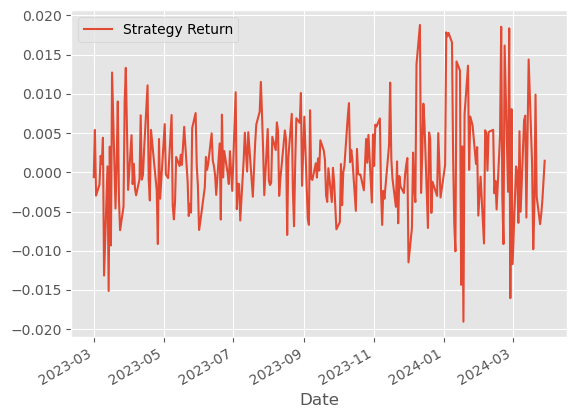

In [27]:
portfolio_df.plot()

In [28]:
klse = yf.download(tickers='^KLSE',
                   start = '2022-01-01',
                   end=dt.date.today())
klse

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-03,1553.640015,1556.280029,1545.530029,1549.050049,1549.050049,65775200
2022-01-04,1550.920044,1551.329956,1536.520020,1541.900024,1541.900024,104133100
2022-01-05,1542.410034,1549.530029,1540.239990,1547.949951,1547.949951,122004900
2022-01-06,1546.459961,1546.500000,1532.599976,1533.359985,1533.359985,126065800
2022-01-07,1534.810059,1543.170044,1531.540039,1543.109985,1543.109985,108158900
...,...,...,...,...,...,...
2024-06-27,1591.530029,1592.260010,1582.310059,1584.939941,1584.939941,198108200
2024-06-28,1583.530029,1590.089966,1581.520020,1590.089966,1590.089966,213091600
2024-07-01,1590.260010,1598.359985,1587.030029,1598.199951,1598.199951,163914800


In [29]:
klse_ret = np.log(klse[['Adj Close']]).diff().dropna().rename({'Adj Close':'KLCI Buy&Hold'},axis=1)

klse_ret

,KLCI Buy&Hold
Date,
2022-01-04,-0.004626
2022-01-05,0.003916
2022-01-06,-0.009470
2022-01-07,0.006338
2022-01-10,0.004565
...,...
2024-06-27,-0.003785
2024-06-28,0.003244
2024-07-01,0.005087


In [30]:
portfolio_df = portfolio_df.merge(klse_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

,Strategy Return,KLCI Buy&Hold
Date,,
2023-03-01,-0.000608,-0.002748
2023-03-02,0.005404,0.003641
2023-03-03,-0.002966,-0.001334
2023-03-06,-0.001550,-0.000599
2023-03-07,0.002098,0.004115
...,...,...
2024-03-22,-0.003079,0.000636
2024-03-25,-0.006602,-0.003149
2024-03-26,-0.005313,0.000572


## Visualize Cumulative Portfolio Returns and Compare to KLCI index

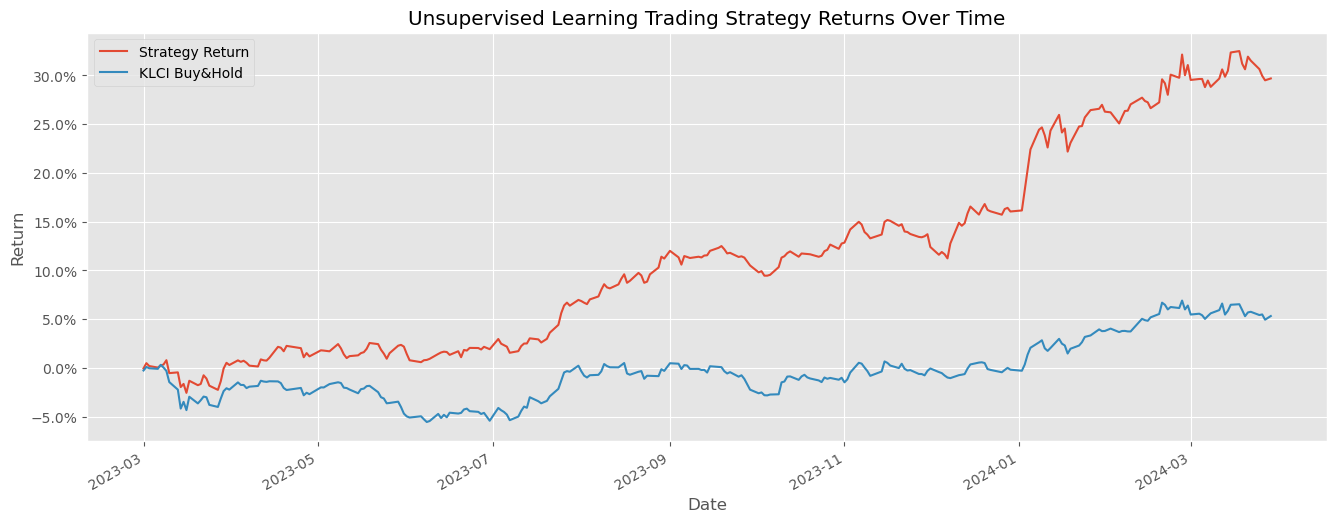

In [31]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-03-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()